# Preparacion de los datos

In [1]:
from utilities import unpickle, tryDataset, mkfolders, os

(50000, 32, 32, 3)


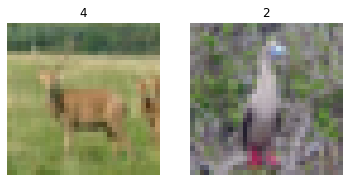

(10000, 32, 32, 3)


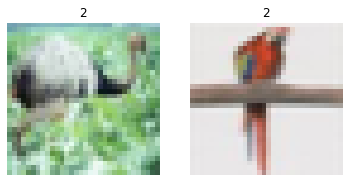

In [2]:
X_train = unpickle("Input\cifar-10-train")
X_test = unpickle("Input\cifar-10-test")
tryDataset(X_train)
tryDataset(X_test)

# Entrenamiento

## Persistencia

In [3]:
_raiz = "Resultados/pruebasAAE"
_nombre = "CIFAR10"

Creamos las carpetas para almacenar el output

In [4]:
mkfolders(_raiz, True)

Carpeta Resultados/pruebasAAE ya existe


## Entrenamiento en grid

In [5]:
from AutoencoderLib import *

Tamaño de la capa latente:

In [6]:
dim_latente_cand = [64]

Tamaño de las imagenes:

In [7]:
img_shape = X_train["data"][0].shape

Parametros:

In [8]:
model_name = "DENSE"

encoder = build_dense_encoder
decoder = build_dense_decoder

discriminators = [(build_discriminator ,"default_disc", {}, {"truth":true_sampler, "truth_kwargs":{}, "falsehood":fake_sampler}),
                    (build_class_discriminator ,"class_disc",{"clases":10}, {"truth":true_sampler_clases, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})]


ae_losses = [(losses.mean_squared_error, "ae_MSE_loss")]
disc_losses =[(losses.binary_crossentropy, "disc_binXentropy_loss")]

In [9]:
epochs = 12

In [12]:
def mainLoop(model_name="MODEL", enc= build_dense_encoder, dec = build_dense_decoder, fit = fit_AAE_twoPhased):
    for ae_loss in ae_losses:
        for disc in discriminators:
            for disc_loss in disc_losses:
                for dim_latente in dim_latente_cand:
                    ruta = _raiz+"\\"+model_name+"\\"+ae_loss[1]+"\\"+disc[1]+"\\"+disc_loss[1]+"\\"+str(dim_latente)
                    if os.path.isfile(ruta+"/Modelos\\decoder.h5") or os.path.isfile(ruta+"/Modelos\\autoencoder.h5"):
                        print(ruta+" ya ha sido entrenada")
                        show_prevResults(ruta, epochs=epochs)
                        continue
                    mkfolders(ruta, True)
                    ck = {"ae_loss": ae_loss[0], "disc_loss":disc_loss[0]}
                    aae = assemble_AAE(dim_latente, img_shape, enc_model = enc, dec_model = dec, disc_model = disc[0], 
                                    compilation_kwargs=ck, disc_kwargs=disc[2])
                    fit_settings = { "epochs":epochs, "ruta" : ruta}
                    fit_settings.update(disc[3])
                    history = fit(aae=aae, dim_latente=dim_latente, dataset=X_train, **fit_settings)
                    print("Historia del entrenamiento:")
                    plot_history(history, ruta=ruta, title=ruta)
                    (encoder, decoder, _, autoencoder) = aae
                    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
                    clases=0
                    if "clases" in disc[2].keys():
                        clases=disc[2]["clases"]
                    sample_imgs(X_train, autoencoder, epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET")
                    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
                    sample_imgs(X_test, autoencoder, epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET")
                    print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):")
                    exploraLatente(encoder, decoder, "Input\cifar-10-groupedtrain", ruta=ruta, nombre="GenFromLatentTRAINSET")
                    print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):")
                    exploraLatente(encoder, decoder, "Input\cifar-10-groupedtest", ruta=ruta, nombre="GenFromLatentTESTSET")
                    mkfolders(ruta+"/Modelos")
                    #decoder.save(ruta+"/Modelos\\decoder.h5")
                    #autoencoder.save(ruta+"/Modelos\\autoencoder.h5")


### Entrenamiento de AAE Denso

Carpeta Resultados/pruebasAAE\DENSE\ae_MSE_loss\default_disc\disc_binXentropy_loss\64 ya existe
EPOCH 0


C:\Users\bitde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch: 0 Step: 99 Disc: (loss = 0.557402, acc = 60.50%) AAE: (mse = 2.848939, b_ce = 0.064605)
Epoch: 0 Step: 199 Disc: (loss = 0.346206, acc = 88.00%) AAE: (mse = 2.810575, b_ce = 0.058018)
Epoch: 0 Step: 299 Disc: (loss = 0.203578, acc = 100.00%) AAE: (mse = 2.590308, b_ce = 0.056566)
Epoch: 0 Step: 399 Disc: (loss = 0.378356, acc = 85.50%) AAE: (mse = 3.663791, b_ce = 0.061091)
Epoch: 0 Step: 499 Disc: (loss = 0.222002, acc = 95.50%) AAE: (mse = 4.837427, b_ce = 0.049514)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.251888, acc = 93.50%) AAE: (mse = 5.247230, b_ce = 0.046072)
Epoch: 1 Step: 199 Disc: (loss = 0.342236, acc = 90.50%) AAE: (mse = 6.064392, b_ce = 0.055135)
Epoch: 1 Step: 299 Disc: (loss = 0.633695, acc = 55.50%) AAE: (mse = 2.706745, b_ce = 0.046842)
Epoch: 1 Step: 399 Disc: (loss = 0.432503, acc = 83.00%) AAE: (mse = 4.396312, b_ce = 0.047020)
Epoch: 1 Step: 499 Disc: (loss = 2.601959, acc = 42.00%) AAE: (mse = 4.173526, b_ce = 0.038632)
EPOCH 2
Epoch: 2 Step: 99 Disc: (

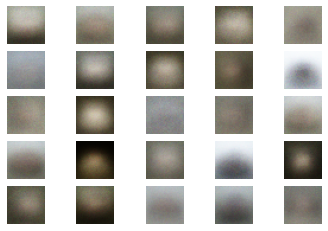

Historia del entrenamiento:


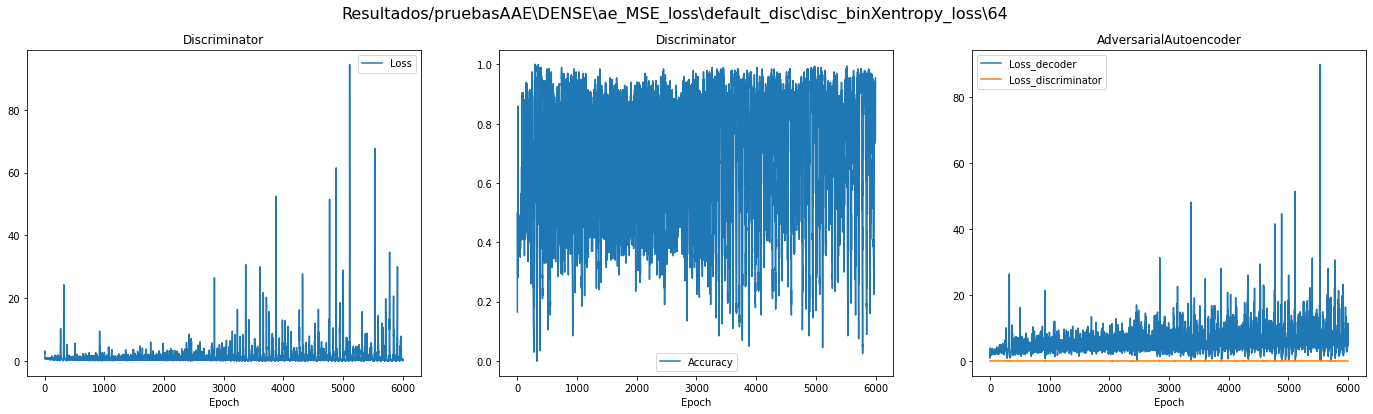

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


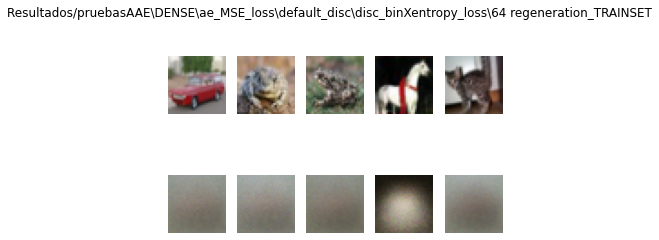

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


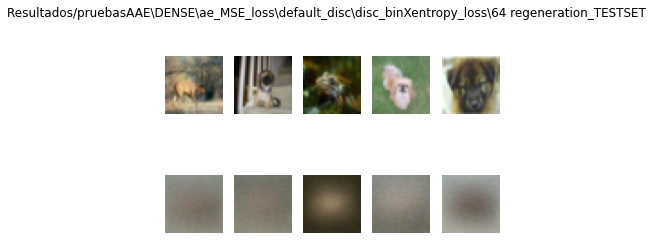

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


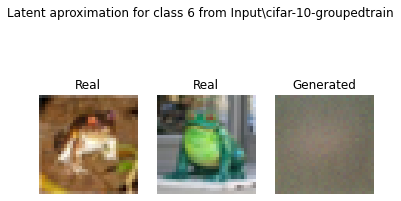

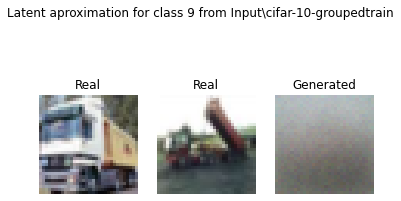

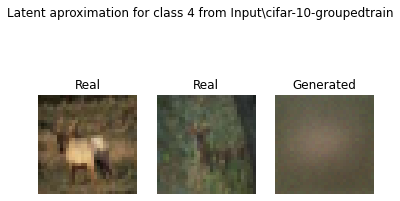

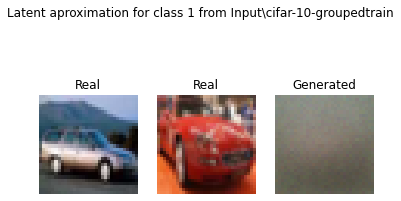

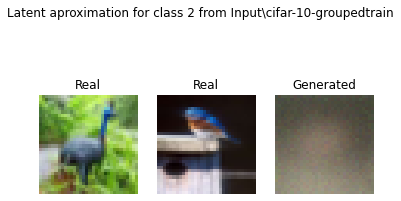

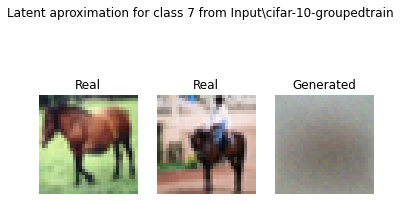

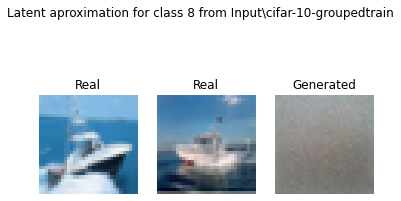

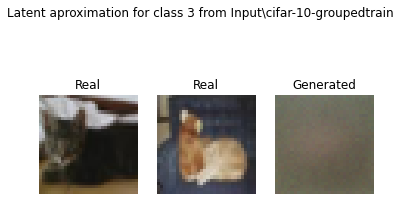

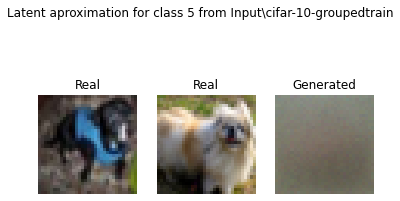

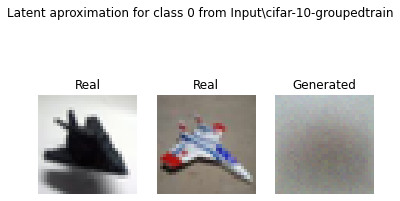

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


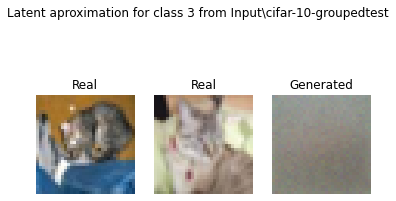

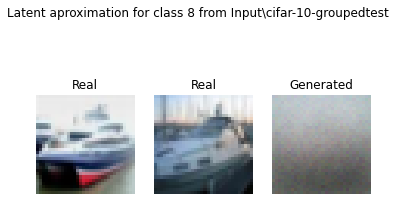

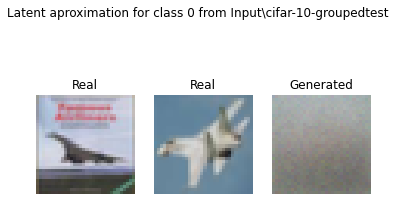

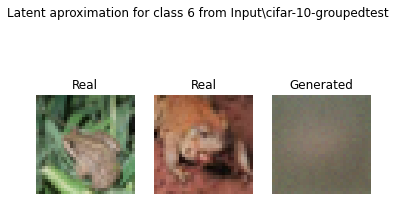

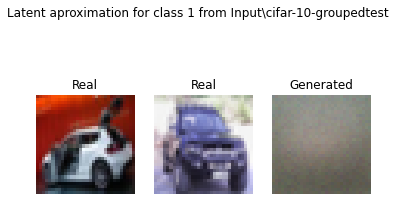

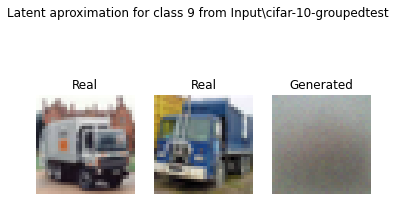

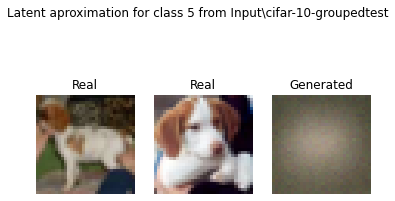

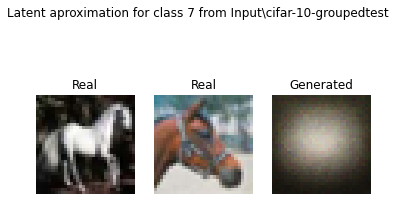

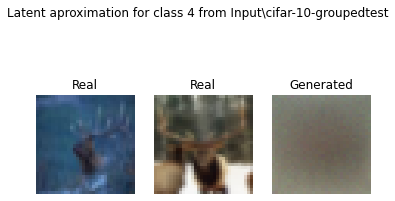

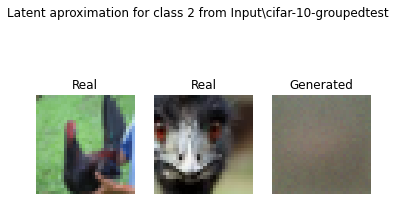

Carpeta Resultados/pruebasAAE\DENSE\ae_MSE_loss\class_disc\disc_binXentropy_loss\64 ya existe
EPOCH 0
Epoch: 0 Step: 99 Disc: (loss = 0.655006, acc = 62.00%) AAE: (mse = 1.022483, b_ce = 0.062530)
Epoch: 0 Step: 199 Disc: (loss = 0.466719, acc = 79.50%) AAE: (mse = 1.624825, b_ce = 0.047085)
Epoch: 0 Step: 299 Disc: (loss = 0.398720, acc = 78.00%) AAE: (mse = 3.323964, b_ce = 0.042445)
Epoch: 0 Step: 399 Disc: (loss = 0.822326, acc = 45.50%) AAE: (mse = 2.545658, b_ce = 0.042971)
Epoch: 0 Step: 499 Disc: (loss = 0.387071, acc = 85.00%) AAE: (mse = 2.987819, b_ce = 0.038180)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.439300, acc = 79.50%) AAE: (mse = 3.238493, b_ce = 0.036265)
Epoch: 1 Step: 199 Disc: (loss = 0.351840, acc = 83.50%) AAE: (mse = 3.609987, b_ce = 0.055329)
Epoch: 1 Step: 299 Disc: (loss = 0.327993, acc = 83.00%) AAE: (mse = 3.536886, b_ce = 0.044982)
Epoch: 1 Step: 399 Disc: (loss = 0.310983, acc = 87.00%) AAE: (mse = 3.973499, b_ce = 0.036370)
Epoch: 1 Step: 499 Disc: (lo

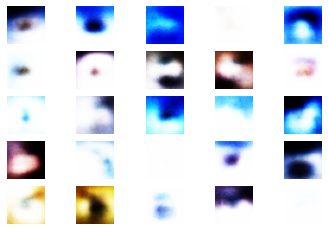

Historia del entrenamiento:


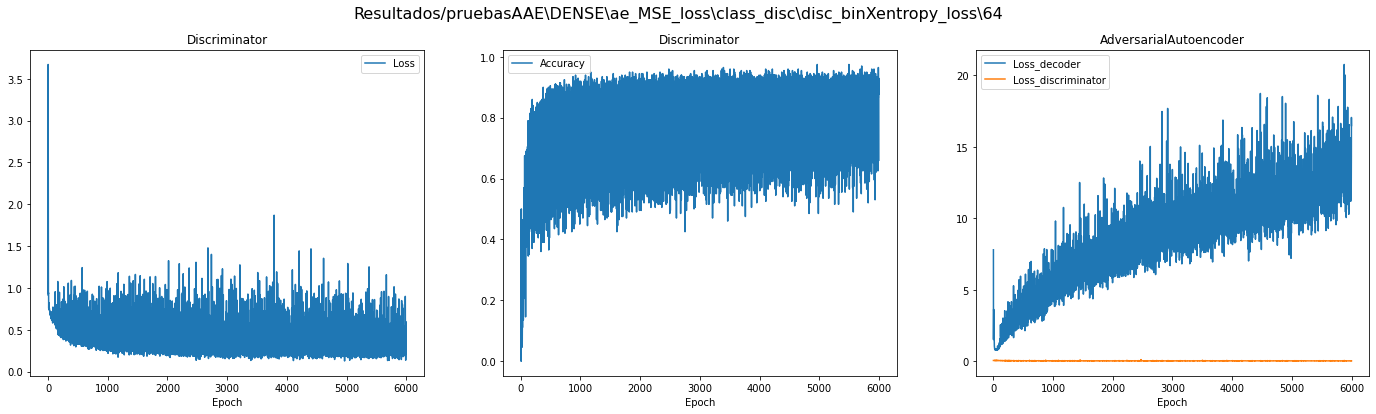

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


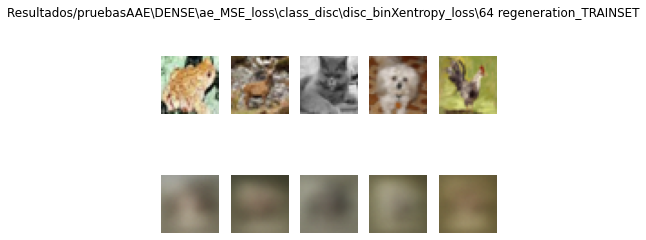

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


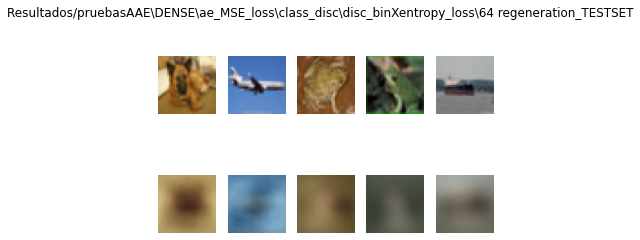

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


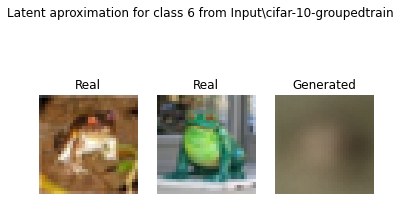

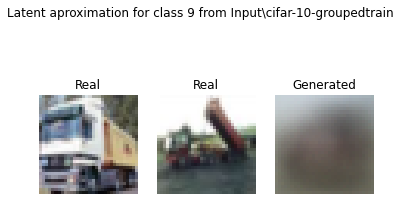

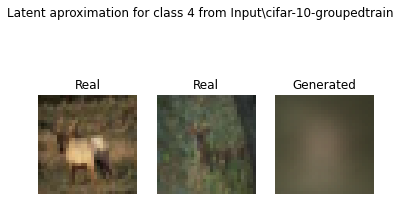

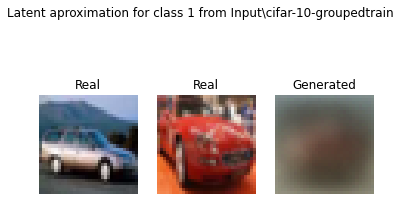

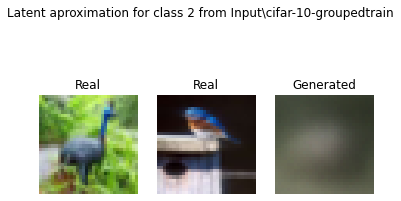

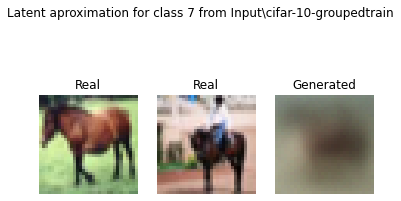

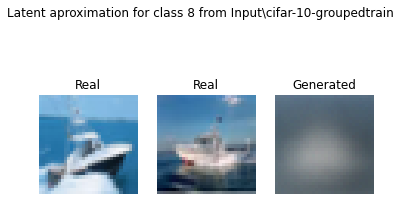

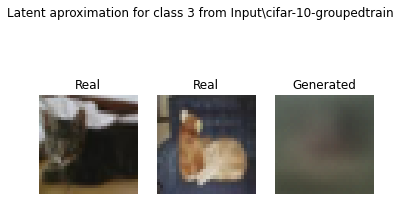

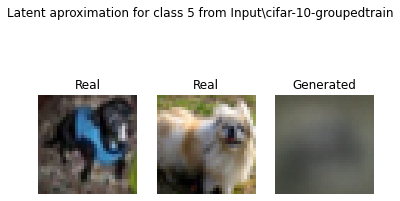

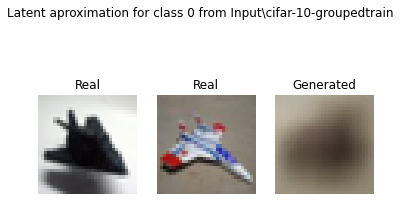

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


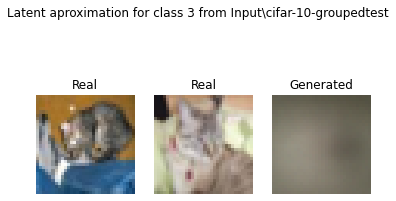

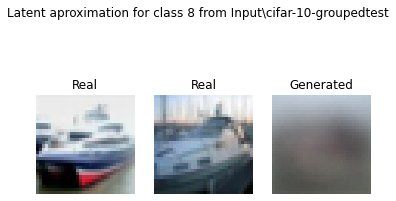

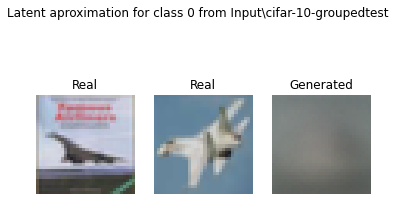

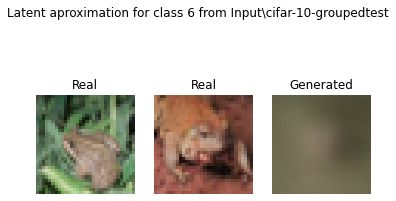

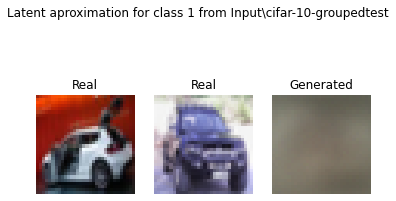

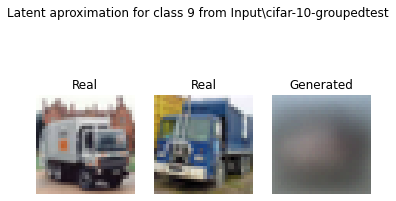

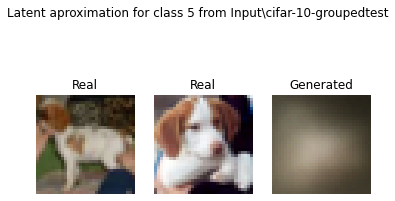

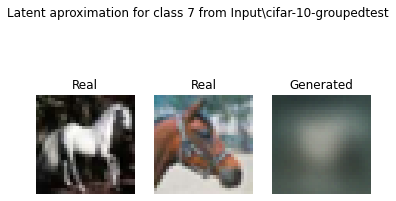

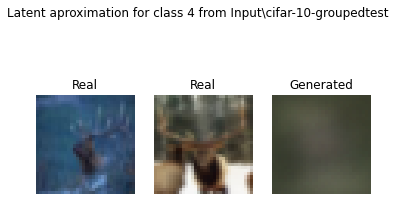

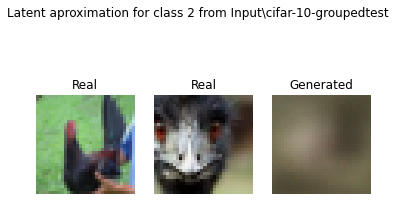

In [13]:


mainLoop(enc=encoder, dec=decoder, model_name=model_name)
